In [ ]:
!unzip ./OPP-115_v1_0.zip -d ./OPP-115

Streaming output truncated to the last 5000 lines.
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/plusone.js  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/postmessageRelay.html  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/prum.min.js  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/pubads_impl_65.js  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/quant.js  
 extracting: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/rd_log  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/redirect  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/require.min.js  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/rt=ifr(1).html  
  inflating: ./OPP-115/OPP-115/original_policies/1673_www.tulsaworld.com_files/rt=ifr.html  
  inflati

In [ ]:
!pip install spacy beautifulsoup4
# !pip -m spacy download en_core_web_sm


In [ ]:
import spacy
import os
from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text(separator=" ")

    doc = nlp(clean_text)

    # Use lemmatization and lowercasing
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct]

    clean_text = " ".join(tokens)
    return clean_text


preprocessed_policies_dict = {}
directory = './OPP-115/OPP-115/sanitized_policies'

for filename in os.listdir(directory):
    if filename.endswith('.html'):
        base_name = '_'.join(filename.split('_')[1:]).rsplit('.', 1)[0]
        path = os.path.join(directory, filename)
        with open(path, 'r', encoding='utf-8') as file:
            html_content = file.read()
            preprocessed_text = preprocess_text(html_content)
            preprocessed_policies_dict[base_name] = preprocessed_text


In [ ]:
import pandas as pd
import os

annotations_dir = './OPP-115/OPP-115/annotations/'

# A dictionary to hold all dataframes, key will be the base filename
dataframes = {}

for annotation_filename in os.listdir(annotations_dir):
    if annotation_filename.endswith('.csv'):
        base_name = '_'.join(annotation_filename.split('_')[1:]).rsplit('.', 1)[0]

        annotation_path = os.path.join(annotations_dir, annotation_filename)

        annotation_df = pd.read_csv(annotation_path, header=None)

        dataframes[base_name] = {'categories': annotation_df[5], 'preprocessed_text': preprocessed_policies_dict.get(base_name)}


yahoo_df = dataframes['yahoo.com']
yahoo_df['categories']


0              Other
1              Other
2              Other
3              Other
4              Other
           ...      
162            Other
163    Policy Change
164            Other
165            Other
166            Other
Name: 5, Length: 167, dtype: object

In [ ]:
from collections import defaultdict
import pandas as pd

# Initialize a list to hold the final consolidated dataset
final_dataset = []

for base_name, data in dataframes.items():
    unique_categories_per_text = defaultdict(set)

    for category in data['categories']:
        unique_categories_per_text[data['preprocessed_text']].add(category)

    for text, categories_set in unique_categories_per_text.items():
        final_dataset.append({
            'source': base_name,
            'preprocessed_text': text,
            'categories': list(categories_set)
        })

final_df = pd.DataFrame(final_dataset)

# Display the shape of the DataFrame and the first few rows to verify the structure
print(final_df.shape)
final_df.head()


(115, 3)


,source,preprocessed_text,categories
0,fredericknewspost.com,privacy policy post tuesday september...,"[User Access, Edit and Deletion, International..."
1,education.jlab.org,privacy and security notice securit...,"[Other, Third Party Sharing/Collection, First ..."
2,boardgamegeek.com,privacy policy geekdo take your privacy s...,"[Other, Third Party Sharing/Collection, Policy..."
3,aol.com,aol privacy policy last update june...,"[User Access, Edit and Deletion, First Party C..."
4,voxmedia.com,vox media privacy policy ||| update as o...,"[User Access, Edit and Deletion, User Choice/C..."


In [ ]:
final_df.iloc[0]['preprocessed_text']

"  privacy policy        post tuesday september 18 2012 12:29 pm        update thursday may 21 2015 3:22 pm          our commitment to you        the frederick news post and its owner randall family llc collectively the news post recognize the importance of protect the privacy of personally identifiable information collect about you our customer this customer privacy policy be intend to outline our legitimate business interest in collect and use information and your reasonable expectation of privacy     |||   security        we take the responsibility for keep your payment and personal information private and secure very seriously when enter payment and personal information on our web page you will see that we use ssl certificate to encrypt your datum as you submit it our internal system and procedure be periodically review for compliance with industry standard on datum security     |||   user information collect        the news post gather identify information about you only when you 

In [ ]:
# First Party Collection/Use	- maps to -> Lawfulness, Fairness, Transparency | Purpose Limitation | Data Minimization

# Third Party Sharing/Collection - maps to ->	Lawfulness, Fairness, Transparency | Purpose Limitation | Data Minimization

# User Choice/Control	 - maps to -> Lawfulness, Fairness, Transparency

# User Access, Edit, and Deletion  - maps to ->	Lawfulness, Fairness, Transparency | Accuracy

# Data Retention  - maps to ->	Storage Limitation

# Data Security  - maps to -> Integrity and Confidentiality

# Policy Change	  - maps to ->	 Lawfulness, Fairness, Transparency

# Do Not Track

# International and Specific Audiences	  - maps to ->	 Lawfulness, Fairness, Transparency

# Other	(No Direct Mapping)

label_mapping = {
    "First Party Collection/Use": [1, 2, 3],
    "Third Party Sharing/Collection": [1, 2, 3],
    "User Choice/Control": [1],
    "User Access, Edit, and Deletion": [1, 4],
    "Data Retention": [5],
    "Data Security": [6],
    "Policy Change": [1],
    "Do Not Track": [],
    "International and Specific Audiences": [1],
    "Other": []
}

# where:

# 1 is lawfulness, fairness and transparency

# 2 is purpose limitation

# 3 is data minimization

# 4 is accuracy

# 5 is storage limitation

# 6 is integrity and confidentiality

# 7 is accountability

def transform_document_labels(document_labels):
    document_new_labels_set = set()
    for label in document_labels:
        # Add the new categories to the set if the label is in the mapping
        if label in label_mapping:
            document_new_labels_set.update(label_mapping[label])
    return sorted(list(document_new_labels_set))

final_df['gdpr_principles'] = final_df['categories'].apply(transform_document_labels)

total_principles = 7

final_df['compliance_percentage'] = final_df['gdpr_principles'].apply(lambda x: (len(x) / total_principles) * 100)

final_df.head()



,source,preprocessed_text,categories,gdpr_principles,compliance_percentage
0,fredericknewspost.com,privacy policy post tuesday september...,"[User Access, Edit and Deletion, International...","[1, 2, 3, 6]",57.142857
1,education.jlab.org,privacy and security notice securit...,"[Other, Third Party Sharing/Collection, First ...","[1, 2, 3]",42.857143
2,boardgamegeek.com,privacy policy geekdo take your privacy s...,"[Other, Third Party Sharing/Collection, Policy...","[1, 2, 3]",42.857143
3,aol.com,aol privacy policy last update june...,"[User Access, Edit and Deletion, First Party C...","[1, 2, 3, 5, 6]",71.428571
4,voxmedia.com,vox media privacy policy ||| update as o...,"[User Access, Edit and Deletion, User Choice/C...","[1, 2, 3, 5, 6]",71.428571


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

encoded_labels = mlb.fit_transform(final_df['gdpr_principles'])


In [ ]:
preprocessed_policies = final_df['preprocessed_text'].tolist()


In [ ]:
!pip install -U transformers
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EvalPrediction
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from transformers import BertConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error

class PrivacyPolicyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)


# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('nlpaueb/legal-bert-base-uncased', num_labels=len(mlb.classes_))

model.classifier = torch.nn.Linear(model.classifier.in_features, len(mlb.classes_))
model.num_labels = len(mlb.classes_)


train_texts, val_texts, train_labels, val_labels = train_test_split(
    preprocessed_policies, encoded_labels, test_size=0.2, random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = PrivacyPolicyDataset(train_encodings, train_labels)
val_dataset = PrivacyPolicyDataset(val_encodings, val_labels)

# def compute_metrics(p: EvalPrediction):
#     preds = np.argmax(p.predictions, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
#     acc = accuracy_score(p.label_ids, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }


def compute_metrics(p: EvalPrediction):
    # Threshold for converting probabilities to binary output
    threshold = 0.5
    # Convert logits to probabilities
    probabilities = torch.sigmoid(torch.tensor(p.predictions)).numpy()
    # Apply threshold to get binary multi-label outputs
    preds = (probabilities > threshold).astype(int)

    # You can compute accuracy in a way that makes sense for your multi-label setup
    # Example: Exact Match Ratio
    exact_match_ratio = np.all(preds == p.label_ids, axis=1).mean()

    # F1 score - average = 'samples' considers each output label's prediction
    f1 = f1_score(p.label_ids, preds, average='samples')

    return {
        'exact_match_ratio': exact_match_ratio,
        'f1_score_samples': f1,
    }


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Exact Match Ratio,F1 Score Samples
1,No log,0.740380,0.000000,0.629296
2,No log,0.692207,0.000000,0.639027
3,No log,0.636752,0.000000,0.720635
4,No log,0.577328,0.521739,0.909903
5,No log,0.503100,0.652174,0.931159
6,No log,0.435522,0.608696,0.936680
7,No log,0.384518,0.652174,0.941511
8,No log,0.349847,0.652174,0.949275
9,No log,0.320461,0.652174,0.949275
10,No log,0.298099,0.652174,0.953934


TrainOutput(global_step=120, training_loss=0.5072651863098144, metrics={'train_runtime': 5697.0804, 'train_samples_per_second': 0.161, 'train_steps_per_second': 0.021, 'total_flos': 242068691066880.0, 'train_loss': 0.5072651863098144, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate()

print(results)


{'eval_loss': 0.2980988025665283, 'eval_exact_match_ratio': 0.6521739130434783, 'eval_f1_score_samples': 0.9539337474120082, 'eval_runtime': 67.0701, 'eval_samples_per_second': 0.343, 'eval_steps_per_second': 0.045, 'epoch': 10.0}


In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
!zip -r saved_model.zip saved_model/

from google.colab import files
files.download('saved_model.zip')


  adding: saved_model/ (stored 0%)
  adding: saved_model/config.json (deflated 54%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/vocab.txt (deflated 51%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/tokenizer_config.json (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r logs.zip logs/
!zip -r results.zip results/


  adding: logs/ (stored 0%)
  adding: logs/events.out.tfevents.1713270310.80fcf865092e.2203.0 (deflated 63%)
  adding: logs/events.out.tfevents.1713276074.80fcf865092e.2203.1 (deflated 27%)
  adding: results/ (stored 0%)


In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained('./saved_model')
# tokenizer = BertTokenizer.from_pretrained('./saved_model')


In [ ]:
!pip install tensorboard

['eval/loss', 'eval/exact_match_ratio', 'eval/f1_score_samples', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
11
11


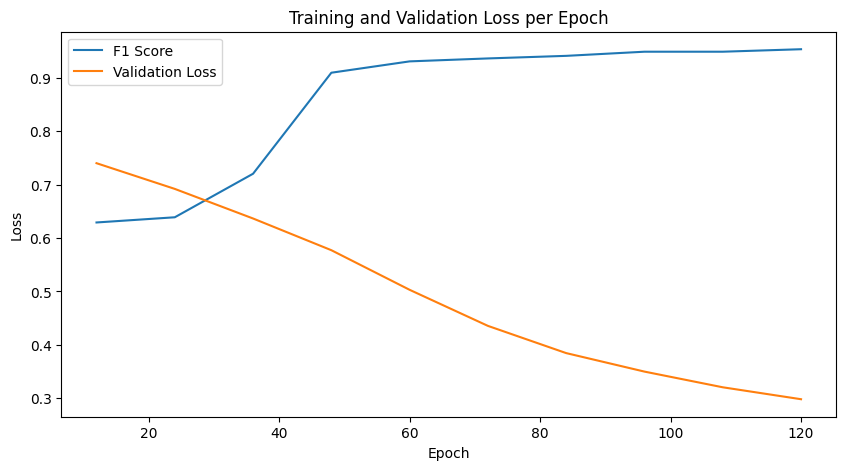

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
logdir = './logs'

# Load the data
ea = event_accumulator.EventAccumulator(logdir)
ea.Reload()  # Loads the data from disk

print(ea.Tags()['scalars'])

# Assuming you have scalar summaries for training and validation loss
training_loss = ea.scalars.Items('eval/f1_score_samples')
validation_loss = ea.scalars.Items('eval/loss')

print(len(training_loss))
print(len(validation_loss))

# Extracting the data for plotting
epochs = [x.step for x in training_loss]
training_losses = [x.value for x in training_loss]
validation_losses = [x.value for x in validation_loss]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='F1 Score')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


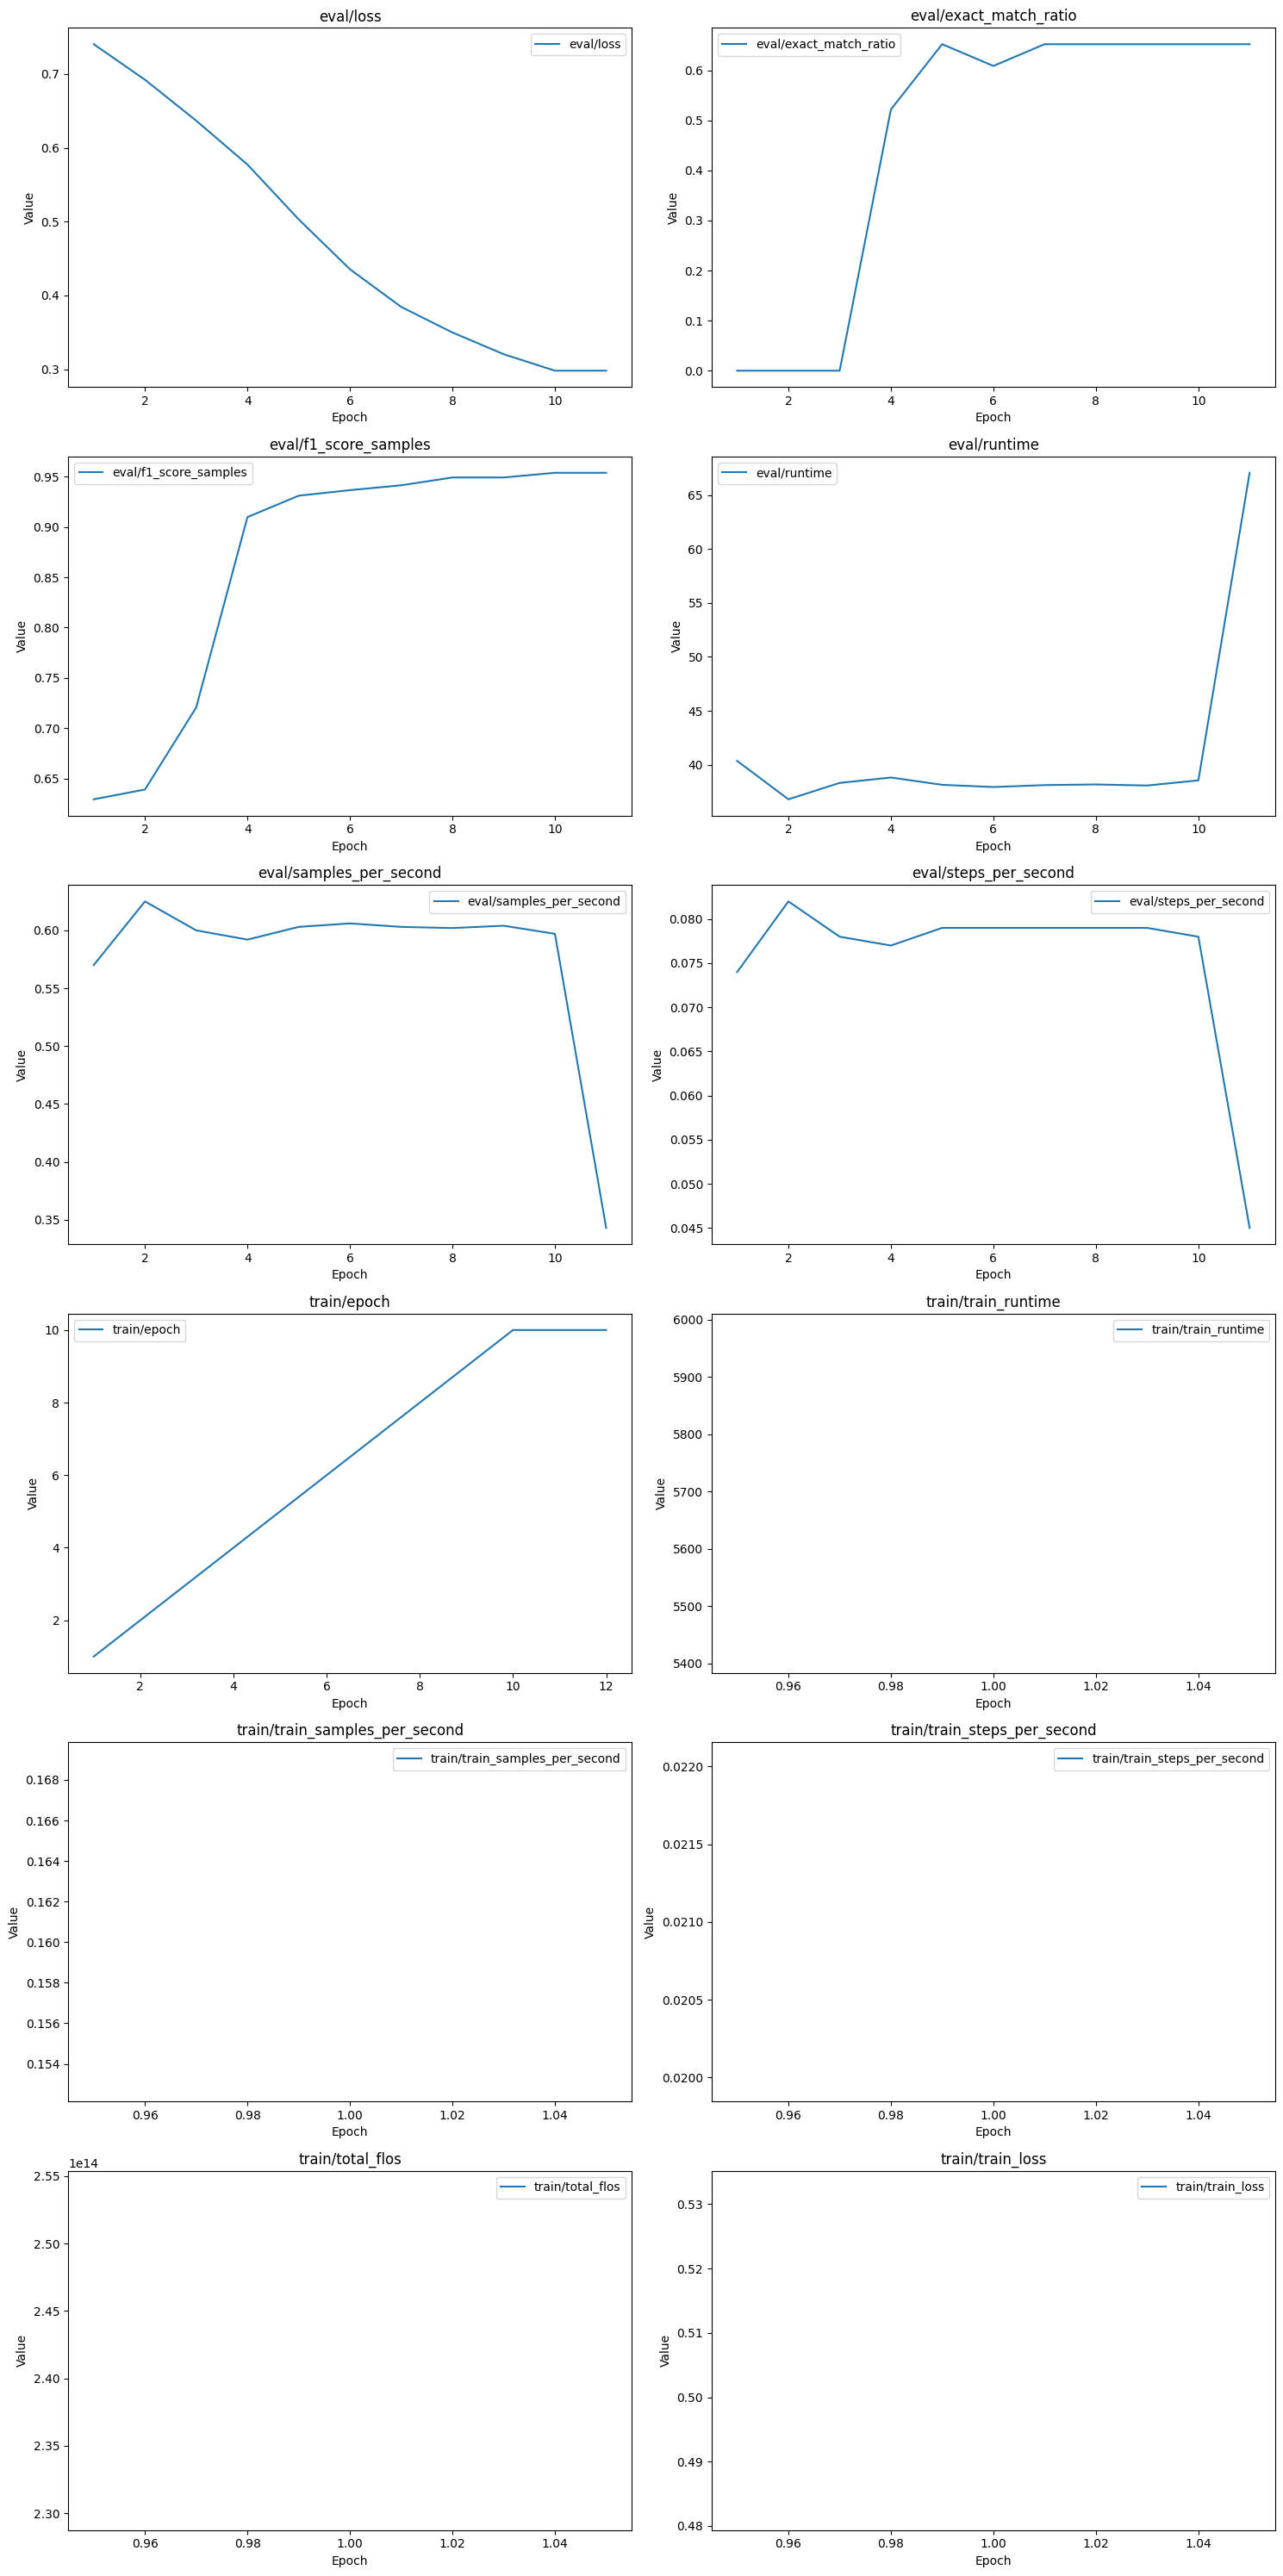

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ea' is your EventAccumulator loaded with TensorBoard logs
ea.Reload()

# Function to extract metric values
def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

# Extract metrics
metrics_dict = {key: extract_metric(key) for key in [
    'eval/loss', 'eval/exact_match_ratio', 'eval/f1_score_samples',
    'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second',
    'train/epoch', 'train/train_runtime', 'train/train_samples_per_second',
    'train/train_steps_per_second', 'train/total_flos', 'train/train_loss'
]}

# Create subplots
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
axs = axs.flatten()  # To iterate easily over subplots for different metrics

# Plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()
